In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import statsmodels
%matplotlib inline



In [2]:
address = 'topcharts.csv'
df = pd.read_csv(address)
df = df.drop(columns= ['Unnamed: 0', 'id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21656 entries, 0 to 21655
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      21656 non-null  float64
 1   artist            21656 non-null  object 
 2   danceability      21656 non-null  float64
 3   duration_ms       21656 non-null  int64  
 4   energy            21656 non-null  float64
 5   explicit          21656 non-null  int64  
 6   instrumentalness  21656 non-null  float64
 7   key               21656 non-null  int64  
 8   liveness          21656 non-null  float64
 9   loudness          21656 non-null  float64
 10  mode              21656 non-null  int64  
 11  title             21656 non-null  object 
 12  popularity        21656 non-null  int64  
 13  release_date      21656 non-null  object 
 14  speechiness       21656 non-null  float64
 15  tempo             21656 non-null  float64
 16  valence           21656 non-null  float6

In [5]:
df.columns

Index(['acousticness', 'artist', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'title', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'topcharts'],
      dtype='object')

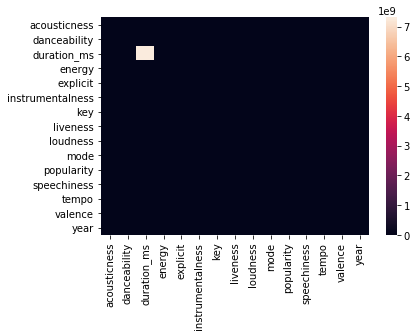

In [3]:
dfCat = df.drop(columns = ['artist', 'title', 'release_date'] ).copy()
sb.heatmap(dfCat.cov())

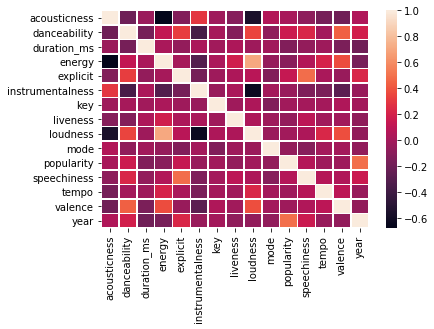

In [4]:
sb.heatmap(dfCat.corr(), linewidths=0.5)

Based off of the correlations of the features we can see that some attributes do not demonstrate any discernible linear relationship. Therefore we should:
#### Keep:
acousticness -  energy, instrumentalness, loudness <br>
danceability - explicit, loudness, valence <br>
energy - acousticness, loudness, valence <br>
explicit - dancability, speechiness <br>
instrumentalness - acousticness, loudness <br>
loudness - acousticness, danceability, instrumentalness, energy, tempo, valence <br>
popularity - year <br>
speechiness - explicit <br>
tempo - loudness <br>
valence - danceability, energy, loudness <br>
year - popularity <br>

#### Drop:
duration <br>
key  <br>
liveness  <br>
mode  <br>

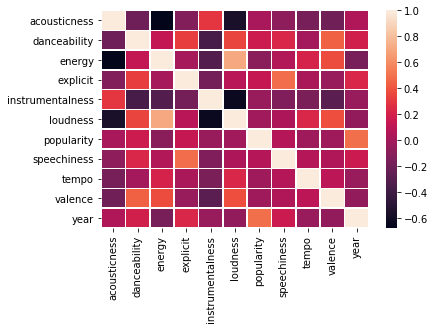

In [5]:
dfCat = dfCat.drop( columns = ['duration_ms', 'key', 'liveness', 'mode'] )
sb.heatmap(dfCat.corr(), linewidths=0.5)


## Preprocessing Part 2

In [10]:
xs = dfCat.drop('topcharts', axis=1)
y = df['topcharts']

In [11]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

In [12]:
ros = SMOTE(random_state=123)
xs_resampled, y_resampled = ros.fit_resample(xs, y)

In [13]:
scaler = StandardScaler()
scaler.fit(xs_resampled)

xs_train, xs_test, y_train, y_test = train_test_split(
    scaler.transform(xs_resampled),
    y_resampled,
    train_size=0.70,
    test_size=0.30,
    stratify=y_resampled,
    random_state=123)

In [14]:
model = LogisticRegression()
model.fit(xs_train, y_train)

LogisticRegression()

## Oversampled Topcharts vs Raw No TopCharts

In [15]:
model.score(xs_test, y_test)

0.7855717819806879

#### We oversampled the Y to get a fair representation

In [26]:
y.value_counts()

N    20884
Y      772
Name: topcharts, dtype: int64

In [50]:
ys = y.copy()

In [53]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=123, replacement=True)
x_rus, y_rus = rus.fit_resample(xs, ys)
y_rus.value_counts()

N    772
Y    772
Name: topcharts, dtype: int64

In [54]:
scaler = StandardScaler()
scaler.fit(x_rus)

xr_train, xr_test, yr_train, yr_test = train_test_split(
    scaler.transform(x_rus),
    y_rus,
    train_size=0.70,
    test_size=0.30,
    stratify=y_rus,
    random_state=123)

In [55]:
model = LogisticRegression()
model.fit(xr_train, yr_train)

LogisticRegression()

In [56]:
model.score(xr_test, yr_test)

0.7629310344827587

In [30]:
# Our Ideal midway point between the two classes are:
half_sample_value = int(y_resampled.value_counts()[0]/2)
half_sample_value

10442

## Combination of Over and Under Sampling techniques

In [57]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
Xse_resampled, yse_resampled = smote_enn.fit_resample(xs, y)
yse_resampled.value_counts()

Y    20119
N    17021
Name: topcharts, dtype: int64

In [59]:
scaler = StandardScaler()
scaler.fit(Xse_resampled)

xse_train, xse_test, yse_train, yse_test = train_test_split(
    scaler.transform(Xse_resampled),
    yse_resampled,
    train_size=0.70,
    test_size=0.30,
    stratify=yse_resampled,
    random_state=123)

In [60]:
model = LogisticRegression()
model.fit(xse_train, yse_train)
model.score(xse_test, yse_test)

0.8169987434930892

In [58]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
Xso_resampled, yso_resampled = smote_tomek.fit_resample(xs, y)
yso_resampled.value_counts()

N    20809
Y    20809
Name: topcharts, dtype: int64

In [61]:
scaler = StandardScaler()
scaler.fit(Xso_resampled)

xso_train, xso_test, yso_train, yso_test = train_test_split(
    scaler.transform(Xso_resampled),
    yso_resampled,
    train_size=0.70,
    test_size=0.30,
    stratify=yso_resampled,
    random_state=123)

In [62]:
model = LogisticRegression()
model.fit(xso_train, yso_train)
model.score(xso_test, yso_test)

0.7818356559346468